In [7]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


dataset = "kidney"
dataset_label = "Kidney"
shap_path = f"./output/{dataset}_shap_values.pt"
shap_values = torch.load(shap_path)

modality_avg = []
for i in range(len(shap_values)):
    sample_sum = np.sum(shap_values[i][:,:,0], axis=1)
    modality_avg.append(np.abs(sample_sum).mean())  
    
modality_avg = np.array(modality_avg)
modality_avg[[1, 2]] = modality_avg[[2, 1]]
df = pd.DataFrame(modality_avg.reshape(1, -1), index=[dataset_label], columns= ["Clinical", "mRNA", "miRNA", "WSI"])
df

,Clinical,mRNA,miRNA,WSI
Kidney,0.057271,0.333507,0.184164,0.311045


In [8]:
all_data_type = ["Clinical", "mRNA", "miRNA", "WSI"]
comb_data = []
for i, modality in enumerate(all_data_type):
    comb_data.append([dataset, modality, modality_avg[i]])
df = pd.DataFrame(comb_data, columns= ["dataset", "modality", "shap_value"])
df

,dataset,modality,shap_value
0,kidney,Clinical,0.057271
1,kidney,mRNA,0.333507
2,kidney,miRNA,0.184164
3,kidney,WSI,0.311045


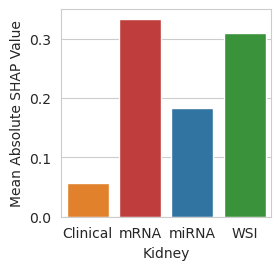

In [9]:
sns.set_style('whitegrid')
colors = [sns.color_palette("tab10")[1], sns.color_palette("tab10")[3], sns.color_palette("tab10")[0], sns.color_palette("tab10")[2]]

g = sns.catplot(x='modality', y='shap_value', col='dataset', kind="bar", data=df, height=3, palette=colors)
for i, ax in enumerate(g.axes.flat):
    ax.set_xlabel(dataset_label)
    ax.set_title('')
sns.despine(top=False, right=False)

g.set_ylabels("Mean Absolute SHAP Value")
plt.show()

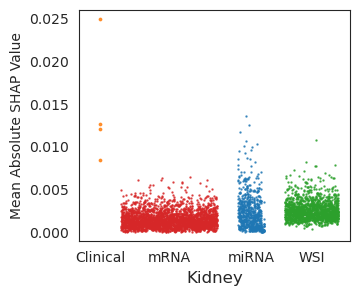

In [10]:
import torch
import numpy as np


sns.set_style('white')
all_data_type = ["clinical", "mRNA", "miRNA", "WSI"]
clinical_len = [2, 1, 3, 2, 1]
clinical_type = ['Cancer Type', 'Gender', 'Race', 'Histological Type', 'Age']
dataset_modality_dim = {'clinical':4, 'mRNA':2746, 'miRNA':743 , 'WSI': 1536}

shap_values = torch.load(shap_path)

mean = []
std = []
dim = []
shap_values[1], shap_values[2] = shap_values[2], shap_values[1] # Swap miRNA and mRNA
for i in range(len(shap_values)):
    if i == 0:
        start = 0
        aggregated_clin = []
        for size in clinical_len:
            end = start + size
            aggregated_clin.append(shap_values[0][:,:, 0][:, start:end].sum(axis=1))
            start = end
        aggregated_clin = np.array(aggregated_clin).T
        mean.append(np.mean(np.abs(aggregated_clin), 0))
        std.append(np.std(np.abs(aggregated_clin), 0))
        dim.append(len(aggregated_clin[0]))
    else:
        mean.append(np.mean(np.abs(shap_values[i][:,:,0]), 0))
        std.append(np.std(np.abs(shap_values[i][:,:,0]), 0))
        dim.append(dataset_modality_dim[all_data_type[i]])
        
space = 600
alpha = 0.8
dot_size = 0.5

plt.figure(figsize=(3.5, 3))
#Clinical
plt.scatter(list(np.arange( space, dim[0] + space)), mean[0], alpha=alpha, color=colors[0], s = 6 * dot_size)

#mRNA
plt.scatter(list(np.arange(dim[0]+ 2* space, np.sum(dim[:2])+2* space)), mean[1], alpha=alpha, color=colors[1], s =dot_size)

#miRNA
plt.scatter(list(np.arange(np.sum(dim[:2])+3*space, np.sum(dim[:3])+3*space)), mean[2], alpha=alpha, color=colors[2], s = dot_size)

# WSI
plt.scatter(list(np.arange(np.sum(dim[:3])+4*space, np.sum(dim)+4*space)), mean[3], alpha=alpha, color=colors[3], s = dot_size)

plt.ylim((-0.001,0.026))
plt.ylabel('Mean Absolute SHAP Value')
plt.yticks([0.0, 0.005, 0.010, 0.015, 0.020, 0.025])

x_tick_space = np.array([0, dim[0]//2, (np.sum(dim[:2]) - dim[0])//2 + dim[0]+ space, (np.sum(dim[:3]) - np.sum(dim[:2]))//2 + np.sum(dim[:2])+ 2* space, (np.sum(dim) - np.sum(dim[:3]))//2 + np.sum(dim[:3])+ 3* space])
x_tick_space += 1* space
x_tick_space[0] = 0
plt.xticks(x_tick_space, ['', 'Clinical', 'mRNA', 'miRNA', 'WSI'])

plt.title(dataset_label, y=-0.22)
plt.show()